In [18]:
# making function library available
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""
# numpy for vector and matrices
import numpy as np

# pandas for working with dataframes
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# for working with dates, etc.
import datetime

# scipy for working with random variables, etc.
from scipy import stats

# typehints
from typing import Union, Tuple

"""
Own packages
"""

from codelib.dal.fred_yield_data import get_nominal_yield_data

# plotting
from codelib.visualization.base import fan_chart

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multivariate Forecating and Fully Flexible Probabilities

## Example: Vector Autoregression of Order 1

In [2]:
# define random seed for reproducibility
np.random.seed(42)

# define 8 colors for plotting
plot_colors = sns.color_palette("rocket", 8)

In [3]:
"""
Load yield curve data.
"""

# sample start
start_date = datetime.datetime(2000, 1, 1)

# maturities in years to use
maturities = [1, 2, 3, 5, 7, 10, 20, 30]

# load US treasury zero coupon yields
zero_yields = get_nominal_yield_data(output_type='zero_yields') / 100.0 # convert to decimal

# select relevant maturities
zero_yields = zero_yields.loc[start_date:, ['SVENY01', 'SVENY02', 'SVENY03', 'SVENY05', 'SVENY07', 'SVENY10', 'SVENY20', 'SVENY30']]

# rename columns
zero_yields.columns = [f'{m}Y' for m in maturities]

# resample weekly
zero_yields = zero_yields.resample('W').last().dropna()

# lenght of sample
T = zero_yields.shape[0]

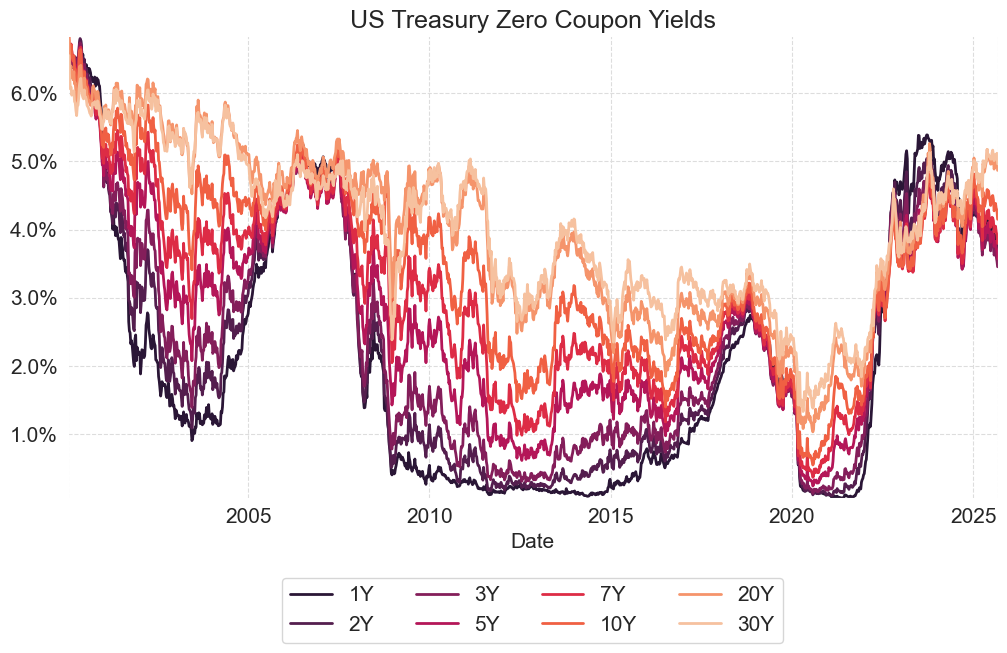

In [4]:
"""
Plot yields
"""

# define figure
fig, ax = plt.subplots(figsize=(12,6))

# plot yields
zero_yields.plot(ax=ax, color=plot_colors)

# set legend below plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# set title
ax.set_title('US Treasury Zero Coupon Yields')

# configure y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [5]:
"""
Estimate VAR(1) model directly with linear algebra
"""

# get data as numpy array
x_mat = zero_yields.values.copy()
# lagged data
x_mat_lagged = x_mat[:-1, :]
# current data
x_mat_current = x_mat[1:, :]
# number of variables
K = x_mat.shape[1]
# add constant to lagged data
x_mat_lagged_const = np.hstack((np.ones((T - 1, 1)), x_mat_lagged))

# estimate coefficients using OLS formula
beta_hat = np.linalg.inv(x_mat_lagged_const.T @ x_mat_lagged_const) @ (x_mat_lagged_const.T @ x_mat_current)

# a parameter, vector of constants
a_hat = beta_hat[0, :]

# b parameter, matrix of coefficients on lagged variables
b_hat = beta_hat[1:, :]

# print results
print('Estimated coefficients, beta_hat:')
print(pd.DataFrame(beta_hat, index=['const'] + [f'lag_{m}Y' for m in maturities], columns=[f'{m}Y' for m in maturities]))

# calculate residuals
eps_hat = x_mat_current - x_mat_lagged_const @ beta_hat
# eps_hat = x_mat_current - a_hat - x_mat_lagged @ b_hat

# variance-covariance matrix of residuals
sigma_eps_hat = np.cov(eps_hat, rowvar=False)
print('Estimated forecast error variance-covariance matrix:')
print(pd.DataFrame(sigma_eps_hat, index=zero_yields.columns, columns=zero_yields.columns))


Estimated coefficients, beta_hat:
               1Y        2Y        3Y        5Y        7Y       10Y       20Y  \
const    0.000166  0.000151  0.000141  0.000173  0.000201  0.000211  0.000226   
lag_1Y   0.885863 -0.092703 -0.133856 -0.074354 -0.031477 -0.039252 -0.091204   
lag_2Y   0.399194  1.656973  0.934583  0.541784  0.307354  0.392509  0.695463   
lag_3Y  -0.809806 -1.670431 -1.143858 -1.372022 -0.973557 -1.131447 -1.595722   
lag_5Y   1.811247  3.405009  3.893248  3.837048  2.364839  2.479453  2.846538   
lag_7Y  -2.094792 -3.652840 -3.992350 -3.075984 -1.679336 -2.683222 -2.897345   
lag_10Y  0.887571  1.494974  1.581743  1.239567  1.089630  2.054220  1.151175   
lag_20Y -0.123094 -0.203027 -0.197868 -0.133683 -0.103473 -0.092881  0.858159   
lag_30Y  0.038435  0.055973  0.051889  0.030154  0.018222  0.013339  0.026770   

              30Y  
const    0.000506  
lag_1Y   0.008027  
lag_2Y  -0.130631  
lag_3Y   0.195830  
lag_5Y  -0.027134  
lag_7Y  -0.018568  
lag_10Y -0.0971

In [6]:
a_hat.shape

(8,)

In [7]:
b_hat.shape

(8, 8)

In [8]:
"""
Define functions for VAR(1) forecasting
"""

def forecast_var(a: np.ndarray, b: np.ndarray, x_init: np.ndarray, h: int, path: bool = True) -> np.ndarray:

    """
    Forecast h-step ahead using VAR(1) model.

    Parameters
    ----------
    a : np.ndarray
        Constant vector of shape (K,) where K is the number of variables.
    b : np.ndarray
        Coefficient matrix of shape (K+1, K) where K is the number of
        variables.
    x_init : np.ndarray
        Initial observation of shape (K,).
    h : int
        Forecast horizon.

    Returns
    -------
    np.ndarray
        Forecasts of shape (h, K).
    """

    k = x_init.shape[0]
    # initialize forecast array
    x_forecast = np.zeros((h, k))
    # set first forecast to initial observation
    x_forecast[0, :] = x_init
    # iterate to get forecasts
    for time_step in range(1, h):
        x_forecast[time_step, :] = a + x_forecast[time_step-1, :] @ b

    if path:
        return x_forecast
    else:
        return x_forecast[-1, :]

In [9]:
"""
Define unconditional mean and variance
"""

def unconditional_moments_var(a: np.ndarray, b: np.ndarray, sigma_eps: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

    """
    Calculate unconditional mean and variance for VAR(1) model.

    Parameters
    ----------
    a : np.ndarray
        Constant vector of shape (K,) where K is the number of variables.
    b : np.ndarray
        Coefficient matrix of shape (K+1, K) where K is the number of
        variables.
    sigma_eps : np.ndarray
        Variance-covariance matrix of error term with shape (K, K).

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Unconditional mean of shape (K,) and variance-covariance matrix of shape (K, K).
    """

    # calculate unconditional mean
    mu = np.linalg.inv(np.eye(b.shape[0]) - b.T) @ a
    # calculate unconditional variance
    cov_mat = np.linalg.solve(np.eye(b.shape[0]**2) - np.kron(b.T, b.T), sigma_eps.flatten()).reshape(b.shape[0], b.shape[0])

    return mu, cov_mat

In [10]:
"""
Calculate unconditional moments
"""

mu_x, cov_mat_x = unconditional_moments_var(a_hat, b_hat, sigma_eps_hat)

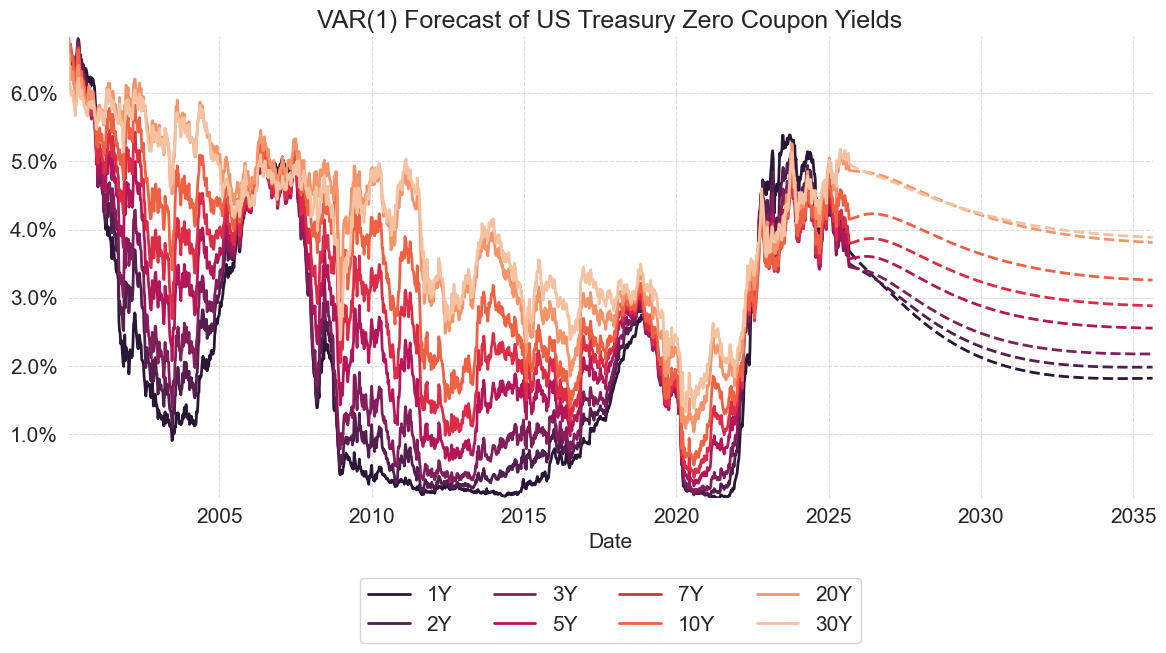

In [14]:

"""
Forecast with VAR(1) model using estimated coefficients and last observation
"""

# last observation
x_last = x_mat[-1, :]
# forecast horizon
h = 52 * 10
# forecast VAR(1)
x_forecast = forecast_var(a_hat, b_hat, x_last, h=h, path=True)
# convert to dataframe
df_x_forecast = pd.DataFrame(x_forecast,
                             columns=zero_yields.columns,
                             index=pd.date_range(start=zero_yields.index[-1] + pd.Timedelta(weeks=1), periods=h, freq='W'))

"""
Plot forecasts
"""

# plot forecasts
fig, ax = plt.subplots(figsize=(14,6))
# plot historical data
zero_yields.plot(ax=ax, color=plot_colors)
# plot forecasts
df_x_forecast.plot(ax=ax, linestyle='--', color=plot_colors)

# plot unconditional mean as horizontal line for one of the yields
# ax.axhline(mu_x[0], color='k')

# add legend, only for historical data
handles, labels = ax.get_legend_handles_labels()
handles = handles[:len(maturities)]
labels = labels[:len(maturities)]
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# set title
ax.set_title('VAR(1) Forecast of US Treasury Zero Coupon Yields')
# configure y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# show plot
plt.show()

# savefig
fig.savefig('var1_yield_forecast_10years.png', bbox_inches='tight', dpi=300)


In [30]:
# variance of h-step ahead forecast errors
def forecast_error_variance(b: np.ndarray, sigma_eps: np.ndarray, h: int) -> np.ndarray:
        """
        Calculate h-step ahead forecast error variance for VAR(1) model.

        Parameters
        ----------
        b : np.ndarray
            Coefficient matrix of shape (K, K) where K is the number of variables.
        sigma_eps : np.ndarray
            Variance-covariance matrix of residuals with shape (K, K).
        h : int
            Forecast horizon.

        Returns
        -------
        np.ndarray
            Forecast error variance-covariance matrix of shape (K, K).
        """

        k = sigma_eps.shape[0]
        # initialize forecast error variance
        var_forecast = np.zeros((k, k))
        # iterate to calculate forecast error variance
        for i in range(h):
            var_forecast += np.linalg.matrix_power(b.T, i) @ sigma_eps @ np.linalg.matrix_power(b, i)

        return var_forecast

In [31]:
"""
Forecast error variance and mean at horizon h
"""

h = 12 # forecast horizon
cov_mat_x_at_horizon = forecast_error_variance(b_hat, sigma_eps_hat, h=12)
mu_x_at_horizon = forecast_var(a_hat, b_hat, x_last, h=12, path=False)

In [32]:
"""
Define function to simulate from VAR(1) model with normal errors
"""

def simulate_normal_vector_autoregression(beta: np.ndarray, sigma: np.ndarray, x_init: np.ndarray, h: int, num_sim: int) -> np.ndarray:
    """
    Simulate h-step ahead forecasts from a VAR(1) model.

    Parameters
    ----------
    beta : np.ndarray
        Coefficient matrix of shape (K+1, K) where K is the number of variables.
    sigma : np.ndarray
        Variance-covariance matrix of shape (K, K).
    x_init : np.ndarray
        Initial observation of shape (K,).
    h : int
        Forecast horizon.
    num_sim : int
        Number of simulations.

    Returns
    -------
    np.ndarray
        Simulated forecasts of shape (n_sim, K).
    """

    a = beta[0, :, np.newaxis]
    b = beta[1:, :].T

    k = sigma.shape[0]
    # initialize array to hold simulations
    simulations = np.zeros((k, num_sim, h + 1))
    # set initial observation for all simulations
    simulations[:, :, 0] = x_init[:, np.newaxis]

    # perform simulations
    for time_step in range(1, h + 1):
        eps_sim = np.random.multivariate_normal(np.zeros(K), sigma, size=num_sim).T
        simulations[:, :, time_step] = a+ b @ simulations[:, :, time_step - 1] + eps_sim

    return simulations

In [49]:
"""
Simulate h-step ahead zero yield
"""

sim_norm_zero_yields = simulate_normal_vector_autoregression(beta_hat, sigma_eps_hat, x_last, h=12, num_sim=100_000)

In [50]:
sim_norm_zero_yields.shape

(8, 100000, 13)

In [51]:
h

12

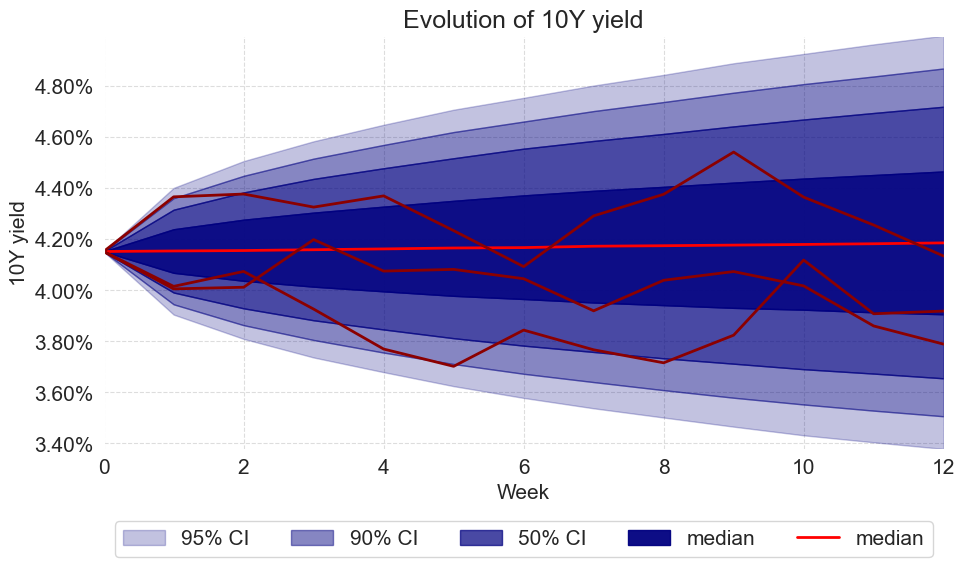

In [52]:
"""
Plot fan chart of simulated 10-year yield h-step ahead forecast
"""
name = '10Y'
idx = zero_yields.columns.get_loc(name)
yields_to_plot = sim_norm_zero_yields[idx, :, :]
time_points = np.arange(0, h+1)

# calculate simulated percentiles for log-fx
percentiles = np.percentile(yields_to_plot, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy", labels=['95% CI', '90% CI', '50% CI', 'median']) # 'navy'

# plot some simulated paths
ax.plot(time_points, yields_to_plot[199, :], color="darkred")
ax.plot(time_points, yields_to_plot[499, :], color="darkred")
ax.plot(time_points, yields_to_plot[999, :], color="darkred")

# set labels and legends
ax.set(ylabel=name + ' yield', xlabel="Week", title="Evolution of {} yield".format(name))

# set percentage format for y-axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# add legend below plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

# savefig
plt.tight_layout()
plt.savefig('fanchart_10y_yield.png', dpi=300)


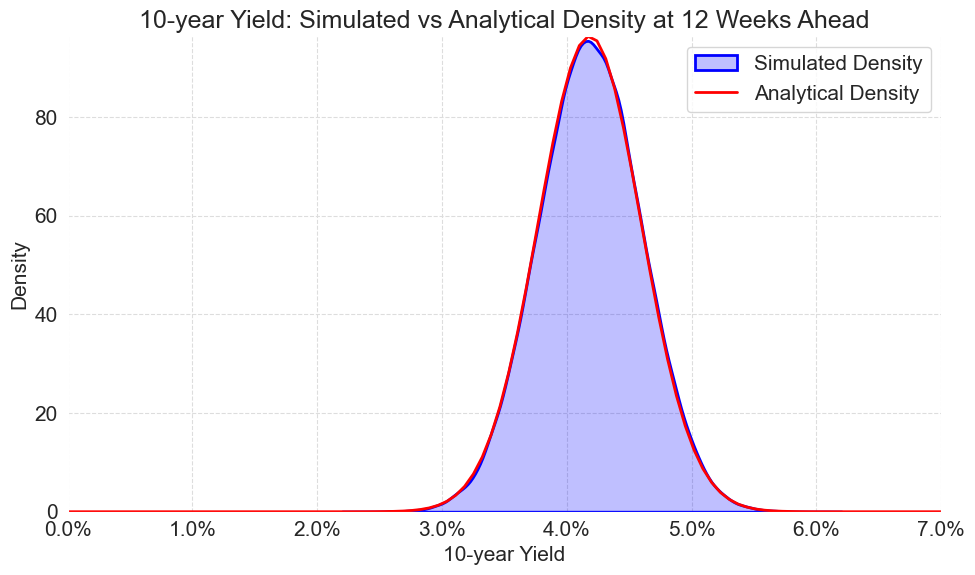

In [57]:
"""
Plot distribution of simulated 10-year yield h-step ahead forecast and compare to analytical distribution
"""

x_vals = np.linspace(0.0, 0.07, 100)
pdf_vals = stats.norm.pdf(x_vals, loc=mu_x_at_horizon[idx], scale=np.sqrt(cov_mat_x_at_horizon[idx, idx]))

# define figure
fig, ax = plt.subplots(figsize=(10, 6))

# plot kernel density estimate of simulated 10-year yield h-step ahead forecast
sns.kdeplot(sim_norm_zero_yields[idx, :, -1], fill=True, color='blue', label='Simulated Density', linewidth=2, ax=ax)

# plot analytical density
ax.plot(x_vals, pdf_vals, color='red', label='Analytical Density', linewidth=2)

# set percentage format for x-axis
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# add legend
ax.legend()

# add title
ax.set_title('10-year Yield: Simulated vs Analytical Density at 12 Weeks Ahead')

# add xlabel
ax.set_xlabel('10-year Yield')

# savefig
plt.tight_layout()
plt.savefig('simulated_vs_analytical_density_10y_yield.png', dpi=300)


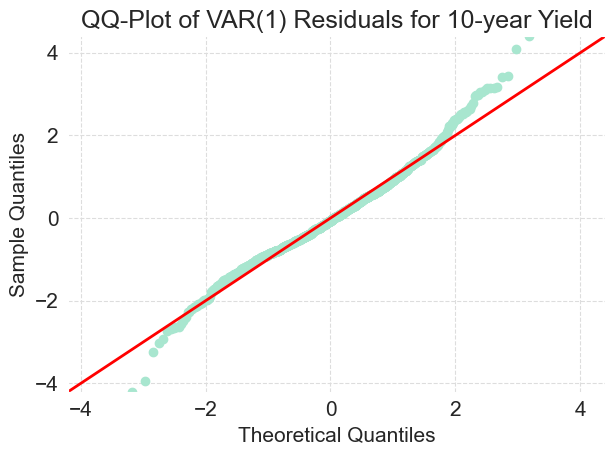

In [62]:
"""
QQ-plot
"""

# plot qq plot
import statsmodels.api as sm

# plot qq plot for 1-year yield
sm.qqplot(eps_hat[:, idx], stats.norm, fit=True, line='45');

# add title
plt.title('QQ-Plot of VAR(1) Residuals for 10-year Yield')

# savefig
plt.tight_layout()
plt.savefig('qq_plot_10y_yield.png', dpi=300)


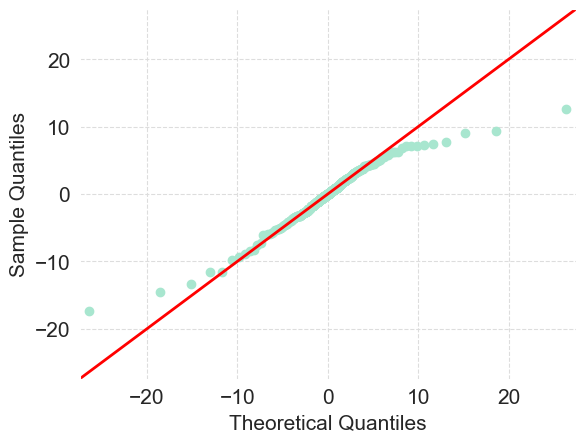

In [61]:

# plot qq plot for 1-year yield
sm.qqplot(eps_hat[:, 0], stats.t, fit=True, line='45');

## Historical Simulation: A Non-Parametric Approach

In [69]:
"""
Simulated distribution of h-step ahead forecasts
"""

def simulate_historical_vector_autoregression(a: np.ndarray, b: np.ndarray, x_init: np.ndarray, h: int, num_sim: int, eps: np.ndarray, probs: np.ndarray=None) -> np.ndarray:
    """
    Simulate h-step ahead forecasts from a VAR(1) model.

    Parameters
    ----------
    a : np.ndarray
        Constant vector of shape (K,) where K is the number of variables.
    b : np.ndarray
        Coefficient matrix of shape (K, K) where K is the number of
        variables.
    x_init : np.ndarray
        Initial observation of shape (K,).
    h : int
        Forecast horizon.
    num_sim : int
        Number of simulations.
    eps : np.ndarray
        Historical residuals of shape (T, K) where T is the number of historical observations

    Returns
    -------
    np.ndarray
        Simulated forecasts of shape (n_sim, K).
    """

    # add dimension to a for broadcasting
    a = a[:, np.newaxis]

    # transpose b for easier matrix multiplication
    b = b.T

    # integers to draw
    integers = np.arange(eps.shape[0])

    k = len(a)
    # initialize array to hold simulations
    simulations = np.zeros((k, num_sim, h + 1))
    # set initial observation for all simulations
    simulations[:, :, 0] = x_init[:, np.newaxis]

    # perform simulations
    for t in range(1, h + 1):
        indices = np.random.choice(integers, size=num_sim, replace=True, p=probs)
        eps_sim = eps[indices, :].T
        simulations[:, :, t] = a + b @ simulations[:, :, t - 1] + eps_sim

    return simulations

In [70]:
"""
Simulate using the historical residuals
"""

sim_hist_zero_yields = simulate_historical_vector_autoregression(a_hat, b_hat, x_last, h=12, num_sim=10_000, eps=eps_hat)

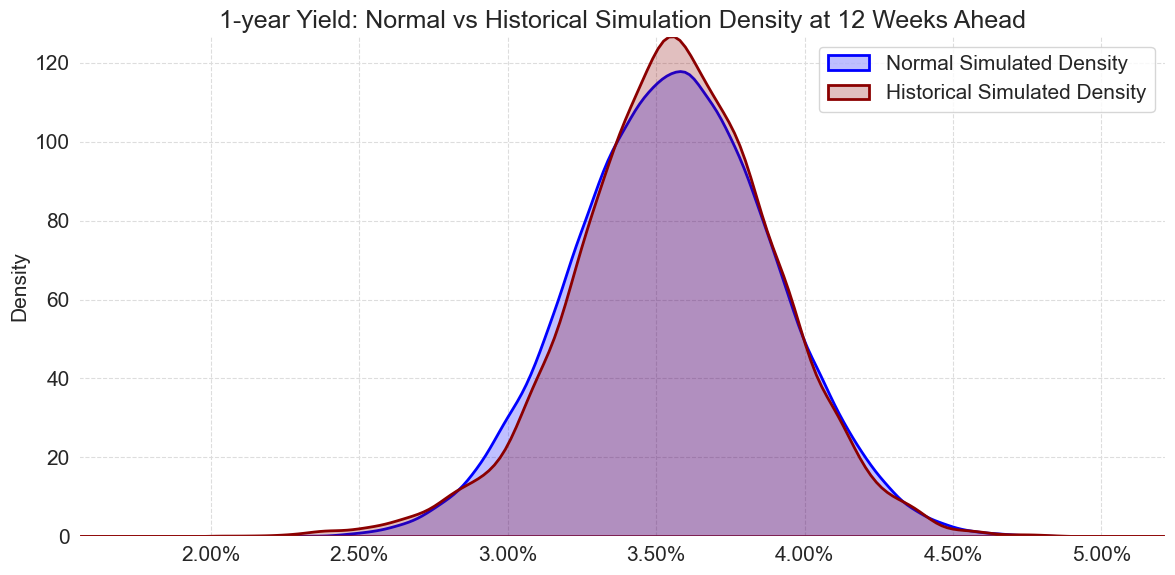

In [77]:
x_vals = np.linspace(0.0, 0.07, 100)
pdf_vals = stats.norm.pdf(x_vals, loc=mu_x_at_horizon[0], scale=np.sqrt(cov_mat_x_at_horizon[0, 0]))

# define figure
fig, ax = plt.subplots(figsize=(12, 6))

# plot kernel density estimate of simulated 1-year yield h-step ahead forecast
sns.kdeplot(sim_norm_zero_yields[0, :, -1], fill=True, color='blue', label='Normal Simulated Density', linewidth=2)

# plot kernel density estimate of simulated 1-year yield h-step ahead forecast
sns.kdeplot(sim_hist_zero_yields[0, :, -1], fill=True, color='darkred', label='Historical Simulated Density', linewidth=2)

# add legend
ax.legend()

# add title
plt.title('1-year Yield: Normal vs Historical Simulation Density at 12 Weeks Ahead')

# set percentage format for x-axis
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))


# savefig
plt.tight_layout()
plt.savefig('simulated_normal_vs_historical_density_1y_yield.png', dpi=300)


## Historical Simulation with Fully Flexible Probabilities

In [78]:
def kernel_smoothing_probs(x: np.ndarray, target: float, bandwidth: float = 1.0) -> np.ndarray:
    """
    Creates an array of kernel smoothing probabilities.

    Currently only works for one state variable.

    Parameters
    ----------
    x:
        Array for setting the shape of.
    target:
        Target value of the state variable.
    bandwidth:
        Bandwidth of the kernel.

    Returns
    -------
    ndarray
        Array of kernel smoothing probabilities.
    """

    kernel_values = np.exp(-0.5 * ((x - target) / bandwidth) ** 2)
    probs = kernel_values / np.sum(kernel_values)

    return probs

In [85]:
"""
Calculate kernel smoothing probabilities based on last observation of 1-year yield
"""

# bandwidth
bandwidth = 0.01
# target value
target = x_last[0]
# calculate probabilities
probs = kernel_smoothing_probs(x_mat_current[:, 0], target=target, bandwidth=bandwidth)
# check that probabilities sum to 1
print(f'Sum of probabilities: {np.sum(probs)}')
# unconditional probabilities
unconditional_probs = np.repeat(1.0 / len(probs), len(probs))

Sum of probabilities: 1.0


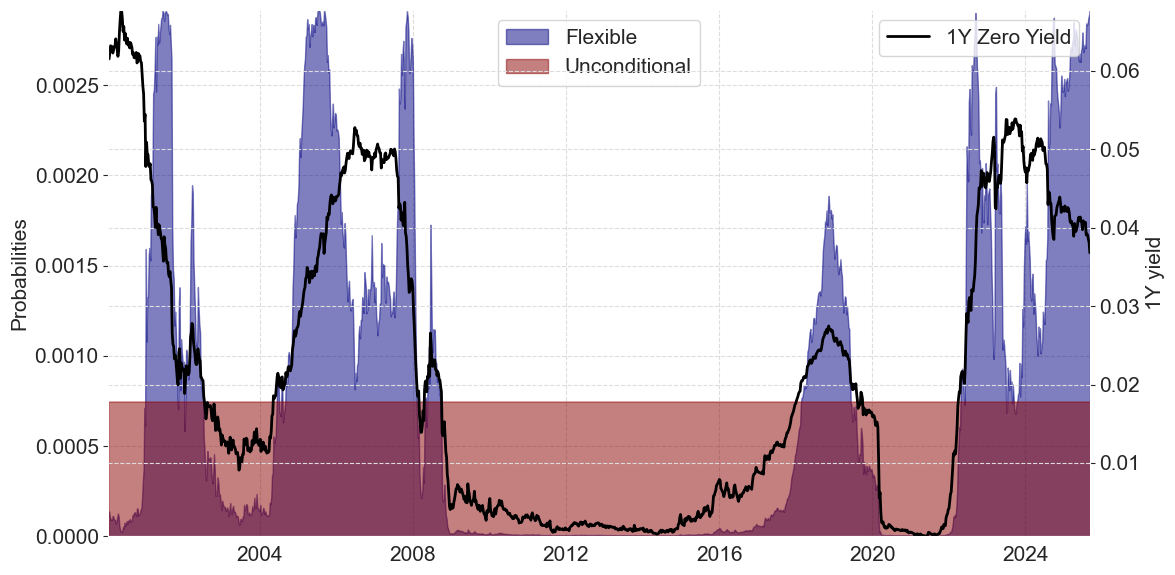

In [94]:
"""
Plot probabilities
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.fill_between(zero_yields.index[1:], probs, label="Flexible", color="navy", alpha=0.5)
ax.fill_between(zero_yields.index[1:], unconditional_probs, label="Unconditional", color="darkred", alpha=0.5)
ax.set_ylabel('Probabilities')

ax.legend(loc="upper center");

ax = ax.twinx()

ax.plot(zero_yields.index[1:], zero_yields['1Y'].iloc[1:], label="1Y Zero Yield", color="black")
ax.set_ylabel('1Y yield');

ax.legend()

# savefig
plt.tight_layout()
plt.savefig('flexible_probabilities_1y_yield.png', dpi=300)

In [88]:
"""
Simulate using the flexible probabilities
"""

sim_flex_zero_yields = simulate_historical_vector_autoregression(a_hat, b_hat, x_last, h=12, num_sim=10_000, eps=eps_hat, probs=probs)

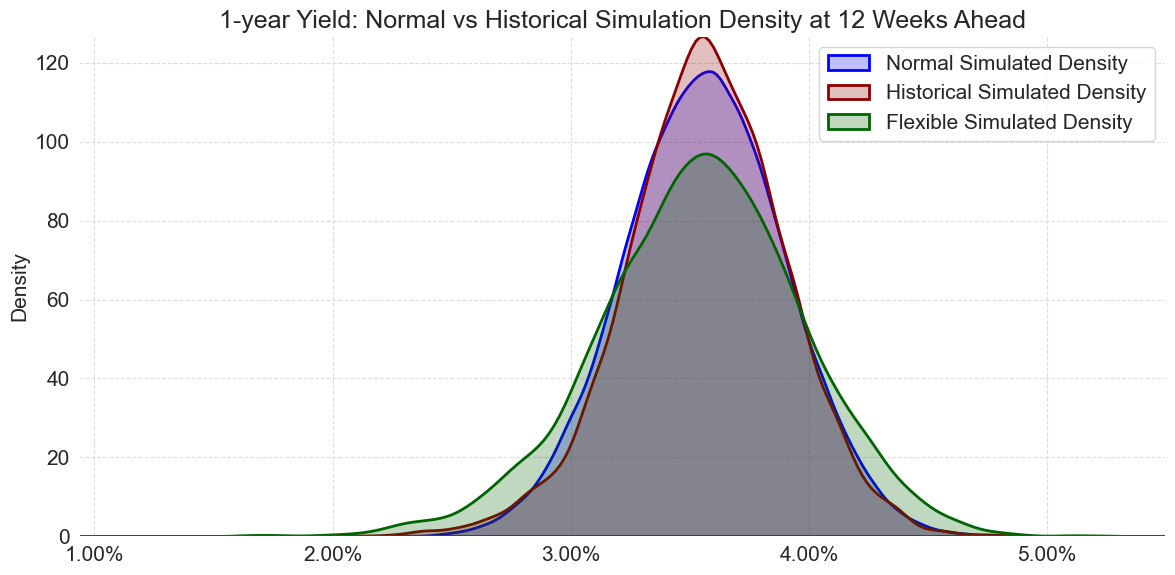

In [90]:
x_vals = np.linspace(0.0, 0.07, 100)
pdf_vals = stats.norm.pdf(x_vals, loc=mu_x_at_horizon[0], scale=np.sqrt(cov_mat_x_at_horizon[0, 0]))

# define figure
fig, ax = plt.subplots(figsize=(12, 6))

# plot kernel density estimate of simulated 1-year yield h-step ahead forecast
sns.kdeplot(sim_norm_zero_yields[0, :, -1], fill=True, color='blue', label='Normal Simulated Density', linewidth=2)

# plot kernel density estimate of simulated 1-year yield h-step ahead forecast
sns.kdeplot(sim_hist_zero_yields[0, :, -1], fill=True, color='darkred', label='Historical Simulated Density', linewidth=2)

# plot kernel density estimate of simulated 1-year yield h-step ahead forecast
sns.kdeplot(sim_flex_zero_yields[0, :, -1], fill=True, color='darkgreen', label='Flexible Simulated Density', linewidth=2)

# add legend
ax.legend()

# add title
plt.title('1-year Yield: Normal vs Historical Simulation Density at 12 Weeks Ahead')

# set percentage format for x-axis
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))


# savefig
plt.tight_layout()
plt.savefig('simulated_with_flexible_1y_yield.png', dpi=300)


# Statsmodels VAR

In [ ]:
"""
Estimate VAR(1) model with tsa
"""

import statsmodels.api as sm
# fit VAR(1) model
model = sm.tsa.VAR(zero_yields)
results = model.fit(maxlags=1)
# print summary
print(results.summary())